[Money Creation Examples](http://www.siebenbrunner.com/moneycreation/) > **Example 5**:
# Lending in Central Bank Digital Currency
We present two possible implementations of a Central Bank Digital Currency (CBDC) in which loans are denoted in CBDC. As discussed in the paper, there is an alternative way to implement CBDCs, where lending would be conducted in commercial bank money, and customers could choose to swap their bank deposits into CBDC at a later stage. This implementation would be completely analogous in terms of booking statements to the change between cash and deposits in the initialization example ([Example 1](http://www.siebenbrunner.com/moneycreation/Ex1_Initialization.html)) and is thus not presented separately here. The two alternatives presented herein are:

- **Direct transfor of CBDC**: the bank grants a loan directly in CBDC by transferring a previously owned stock of CBDC to the debtor (Version 1).
- **Loan transfer from the central bank**: the loan is created by in CBDC by the central bank and subsequently transferred to a commercial bank (Version 2).

We start by importing required utilities.

In [1]:
import os
import sys

base_path = os.path.realpath(os.getcwd()+"/../..")
sys.path.append(base_path)

from abcFinance import Ledger, Account, AccountSide

We further define a function that computes the money stocks according to our defined taxonomy. Note that we do not count CBDC held by banks as part of the total money stock, in analogy to physical cash and in accordance with the definition adopted in our paper. In practice, central banks will have to decide whether to include CBDC held by banks in the money stock.

In [2]:
from contextlib import suppress
from IPython.core.display import SVG
from IPython.display import display_svg

def print_money_stocks():
    # Bank money: bank liabilities that are money
    bank_money = private_agent.get_balance('Deposits')[1]
    central_bank_money = private_agent.get_balance('CBDC')[1]
    
    with suppress(Exception):
        bank_money += private_agent2.get_balance('Deposits')[1]
        central_bank_money += private_agent2.get_balance('CBDC')[1]

    print("Commercial Bank Money:",bank_money)
    print("Central Bank Money:",central_bank_money)
    print("Total (Bank) Money:",central_bank_money+bank_money)

def print_balance_sheets_and_money_stocks():
    bank_balance_sheet = SVG(bank.draw_balance_sheet("Bank Balance Sheet"))
    central_bank_balance_sheet = SVG(central_bank.draw_balance_sheet("Central Bank Balance Sheet"))
    if private_agent.get_total_assets() > 0:
        private_agent_balance_sheet = SVG(private_agent.draw_balance_sheet("Private Agent Balance Sheet"))
        display_svg(bank_balance_sheet, central_bank_balance_sheet, private_agent_balance_sheet)
    else:
        display_svg(bank_balance_sheet, central_bank_balance_sheet)
    print_money_stocks()


## Version 1: Direct Transfer of CBDC from Commercial Bank to Private Sector Agent
In this implementation of a CBDC, banks grant loans directly in CBDC by transferring a stock of CBDC which they already own to the borrower. CBDC lending in this implementation is similar to (but not the same as) how loanable-funds theories describe lending: commercial banks are exogeneously constrained in their ability to grant loans by the availability of CBDC. In contrast to loanable funds theories, however, the limiting resource - CBDC instead of deposits - is an asset for the bank, not a liability.

We start the example by defining a bank, central bank and private sector agent.

In [3]:
bank = Ledger(residual_account_name="Equity")
central_bank = Ledger(residual_account_name="Equity")
private_agent = Ledger(residual_account_name="Equity")

bank.make_asset_accounts(['CBDC','Loans'])
bank.make_liability_accounts(['Deposits'])

private_agent.make_asset_accounts(['CBDC','Deposits'])
private_agent.make_liability_accounts(['Loans'])

central_bank.make_asset_accounts(['Assets'])
central_bank.make_liability_accounts(['CBDC'])

We initialize the system by endowing the commercial and central bank with some initial stock of money.

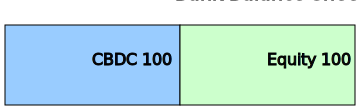

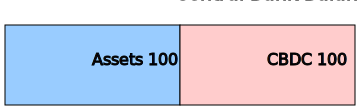

Commercial Bank Money: 0
Central Bank Money: 0
Total (Bank) Money: 0


In [4]:
bank.book(debit=[('CBDC',100)],credit=[('Equity',100)])
central_bank.book(debit=[('Assets',100)],credit=[('CBDC',100)])
print_balance_sheets_and_money_stocks()

The bank now uses parts of its pre-existing stock of CBDC to grant a loan. Note that since we excluded the CBDC held by the bank from the money supply, this transaction has the effect of increasing the money stock.

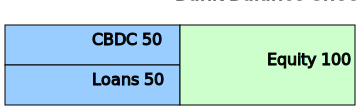

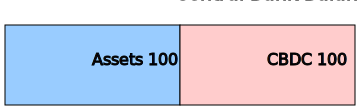

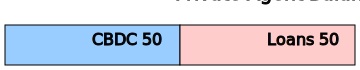

Commercial Bank Money: 0
Central Bank Money: 50
Total (Bank) Money: 50


In [5]:
bank.book(debit=[('Loans',50)],credit=[('CBDC',50)])
private_agent.book(debit=[('CBDC',50)],credit=[('Loans',50)])
print_balance_sheets_and_money_stocks()

## Version 2: Loan transfer from the Central Bank to Commercial Bank
An alternative implementation of lending in CBDC would consist in the central bank intially granting the loan, using the same booking statements that commercial banks use for granting loans in bank money currently. In the second step, the loan would be transferred to a commercial bank, in exchange for CBDC. As we will demonstrate, this implementation of CBDC lending results in the same final state if there are no defaults (Case 2a). The booking statements, however, are different, and as we will demonstrate this means that the central bank bears a type of settlement risk similar to [Herstatt risk](https://en.wikipedia.org/wiki/Settlement_risk) (Case 2b).

We start by defining a set of agents again. We include a second private agent and flow accounts for the other agents. These additions will be needed to book the effects of a materialization of Herstatt risk for the central bank in case 2a.

In [6]:
bank = Ledger(residual_account_name="Equity")
central_bank = Ledger(residual_account_name="Equity")
private_agent = Ledger(residual_account_name="Equity")
private_agent2 = Ledger(residual_account_name="Equity")

bank.make_asset_accounts(['CBDC','Loans'])
bank.make_liability_accounts(['Deposits'])
bank.make_flow_accounts(['Expenses','Impairments'])

private_agent.make_asset_accounts(['CBDC','Deposits'])
private_agent.make_liability_accounts(['Loans'])
private_agent.make_flow_accounts(['Expenses'])

private_agent2.make_asset_accounts(['CBDC','Deposits'])
private_agent2.make_flow_accounts(['Revenues','Impairments'])

central_bank.make_asset_accounts(['Assets','Loans'])
central_bank.make_liability_accounts(['CBDC'])
central_bank.make_flow_accounts(['Impairments'])

### Case 2a: Favourable case
We first start by endowing the agents with some initial money allocations, similar to the first example:

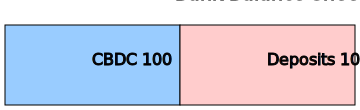

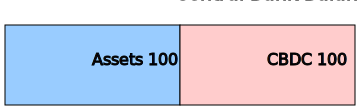

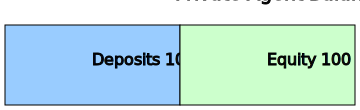

Commercial Bank Money: 100
Central Bank Money: 0
Total (Bank) Money: 100


In [7]:
bank.book(debit=[('CBDC',100)],credit=[('Deposits',100)])
private_agent.book(debit=[('Deposits',100)],credit=[('Equity',100)])
central_bank.book(debit=[('Assets',100)],credit=[('CBDC',100)])
print_balance_sheets_and_money_stocks()

Now the loan granting happens: note that the bank expands its balance sheet by creating new CBDC, just as a commercial bank would do when creating a deposit in the course of granting a loan, and thereby increases the total money stock:

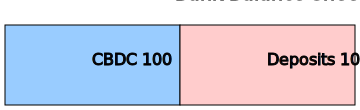

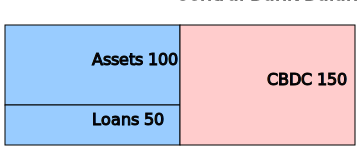

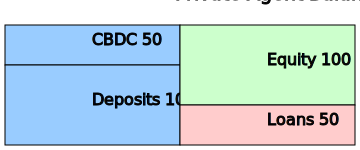

Commercial Bank Money: 100
Central Bank Money: 50
Total (Bank) Money: 150


In [8]:
central_bank.book(debit=[('Loans',50)],credit=[('CBDC',50)])
private_agent.book(debit=[('CBDC',50)],credit=[('Loans',50)])
print_balance_sheets_and_money_stocks()

The commercial bank now uses some of its stock of CBDC to purchase the loan from the central bank. This process destroys CBDC, it does not impact total money stocks, however, as the CBDC held by the bank was excluded from the total money stock by definition. This transaction thus has no more impact on money stocks, and the resulting balance sheets look the same as in the first version of CBDC lending, where the bank directly transferred its pre-existing CBDC stock to the borrower.

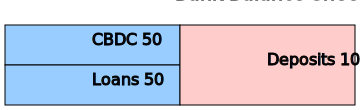

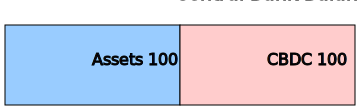

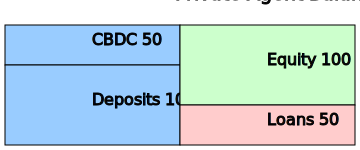

Commercial Bank Money: 100
Central Bank Money: 50
Total (Bank) Money: 150


In [9]:
bank.book(debit=[('Loans',50)],credit=[('CBDC',50)])
central_bank.book(debit=[('CBDC',50)],credit=[('Loans',50)])
print_balance_sheets_and_money_stocks()

### Case 2b: Unfavourable case (Herstatt-type risk materialization)
In order to demonstrate the economic difference between the two versions of CBDC lending, we now assume that the central bank creates another loan for the same private agent. The intial loan creation booking statement and the effect on the money stock is identical.

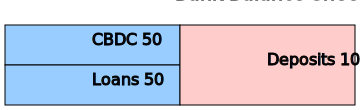

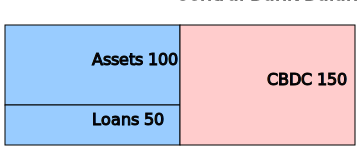

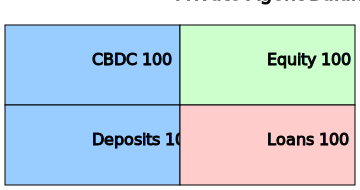

Commercial Bank Money: 100
Central Bank Money: 100
Total (Bank) Money: 200


In [10]:
central_bank.book(debit=[('Loans',50)],credit=[('CBDC',50)])
private_agent.book(debit=[('CBDC',50)],credit=[('Loans',50)])
print_balance_sheets_and_money_stocks()

However, before the bank can purchase the loan from the central bank, it is met with an unexpected shock in the form having to make a payment to another agent, depleting its stock of CBDC:

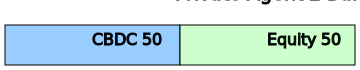

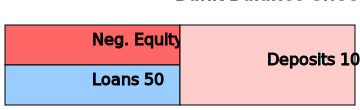

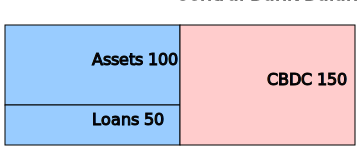

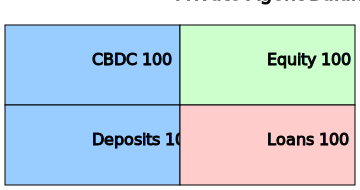

Commercial Bank Money: 100
Central Bank Money: 150
Total (Bank) Money: 250


In [11]:
bank.book(debit=[('Expenses',50)],credit=[('CBDC',50)])
private_agent2.book(debit=[('CBDC',50)],credit=[('Revenues',50)])
bank.book_end_of_period()
private_agent2.book_end_of_period()
display_svg(SVG(private_agent2.draw_balance_sheet("Private Agent 2 Balance Sheet")))
print_balance_sheets_and_money_stocks()

With the realization of this shock, the balance sheet of the central bank now looks different from the first version and also from the previous case. However, this event alone does not mean that the central bank is facing losses. It is now only faced with a credit risk which it was expecting to be able to transfer to the commercial bank. We now assume that this credit risk materializes as the first private agent, who was taken out two loans worth 100 in total so far, is also met with an unexpected shock and has to make a payment to another private agent.

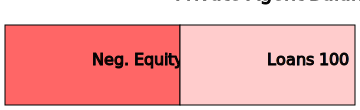

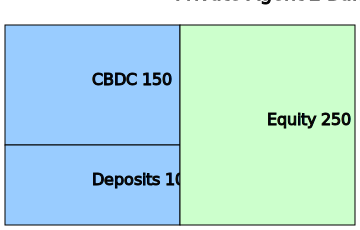

In [12]:
private_agent.book(debit=[('Expenses',200)],credit=[('CBDC',100),('Deposits',100)])
private_agent2.book(debit=[('CBDC',100),('Deposits',100)],credit=[('Revenues',200)])
private_agent.book_end_of_period()
private_agent2.book_end_of_period()
display_svg(SVG(private_agent.draw_balance_sheet("Private Agent Balance Sheet")))
display_svg(SVG(private_agent2.draw_balance_sheet("Private Agent 2 Balance Sheet")))

Since the debtor is now insolvent and has no more assets, both its creditors (the central bank and the commercial bank) now have to write down their exposures. Note that this impairment means that the commercial bank is now insolvent. Hence, all creditors of the commercial bank now have to write down their exposures towards the commercial bank, and we observe the start of a small default cascade. Note that in practice, under current regulations, the default of the commercial bank might trigger a number of bail-in or bail-out mechanisms in the form of e.g. a deposit insurance fund bailing or the government bailing out depositors or all creditors.

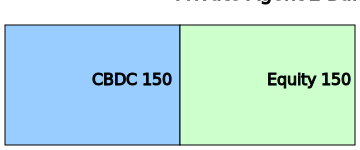

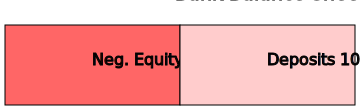

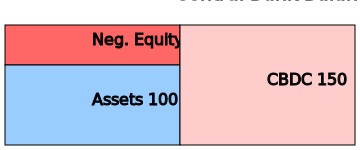

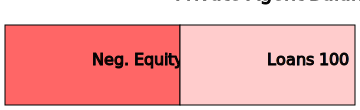

Commercial Bank Money: 0
Central Bank Money: 150
Total (Bank) Money: 150


In [13]:
bank.book(debit=[('Impairments',50)],credit=[('Loans',50)])
private_agent2.book(debit=[('Impairments',100)],credit=[('Deposits',100)])
central_bank.book(debit=[('Impairments',50)],credit=[('Loans',50)])
bank.book_end_of_period()
private_agent2.book_end_of_period()
central_bank.book_end_of_period()
display_svg(SVG(private_agent2.draw_balance_sheet("Private Agent 2 Balance Sheet")))
print_balance_sheets_and_money_stocks()